In [56]:
import sqlite3
import pandas as pd
import pathlib
import json
import re
from tqdm import tqdm
from bertopic import BERTopic
import pickle
import bz2
from tqdm.contrib.concurrent import process_map
from collections import defaultdict
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
from itertools import cycle
from scipy.stats import bernoulli
import random
from operator import concat
from functools import reduce

see get_seeded_mp.py for the script to pull comments from the reddit data wrt., seed terms

see cut_comments which takes the comments.json and indices.json output from get_seeded_mp.py and extracts, for this analysis, the 2015 'poor comments'

see topic_model.py which performs topic modelling on the above 2015 poor comments subset. see the script for details

In [57]:
import sys
sys.version

'3.10.4 (main, Mar 31 2022, 03:37:37) [Clang 12.0.0 ]'

## Load comments, indices, config

In [58]:
with open('config.json', 'r', encoding='utf-8') as f:
    config = json.load(f)

In [59]:
with open('comments.json', 'r', encoding='utf-8') as f:
    comments = json.load(f)

In [60]:
with open('indices.json', 'r', encoding='utf-8') as f:
    indices = json.load(f)
indices = {k:[tuple(p) for p in indices[k]] for k in tqdm(indices.keys())}

100%|██████████████████████████████████████████| 41/41 [00:00<00:00, 132.00it/s]


## Load the topic_model

In [61]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
topic_model = BERTopic.load("topic_model.safetensors", embedding_model=embedding_model)

### get a dataframe of topics wrt., all comments

In [62]:
ordered_comments = reduce(concat, [comments[seed] for seed in comments.keys()])
df_topic = topic_model.get_document_info(ordered_comments)

In [63]:
df_topic.shape

(1904437, 7)

### collapse rows which are the same comment (have the same comment index)

In [64]:
df_topic['index'] = [index for seed in indices.keys() for index in indices[seed]]
df_topic = df_topic.drop_duplicates(subset=['index'], keep='first')

In [65]:
df_topic.shape

(1830354, 8)

## rows by context type

In [66]:
poor_indices = set([index for seed in config['wealth_seeds']['poor_seeds'] for index in indices[seed]])
rich_indices = set([index for seed in config['wealth_seeds']['rich_seeds'] for index in indices[seed]])
neutral_indices = set(indices['neutral_sample'])
black_indices = set([index for seed in config['other_seeds']['black_seeds'] for index in indices[seed]])
n_indices = set([index for seed in config['other_seeds']['n_seeds'] for index in indices[seed]])

In [67]:
display(len(poor_indices.intersection(rich_indices)))
display(len(poor_indices.intersection(black_indices)))
display(len(neutral_indices.intersection(black_indices)))
display(len(poor_indices.intersection(n_indices)))
display(len(neutral_indices.intersection(n_indices)))

14397

4395

995

413

290

In [68]:
# pure poor_context indices (as not coincident with rich) and vice-versa
poor_indices_pure = poor_indices - rich_indices
rich_indices_pure = rich_indices - poor_indices

# RQ1

## flag comments as containing a key word from selected topics

In [69]:
RQ1_selected = [
    ('police', 'cops ', 'police officer', 'cop ',), 
    ('prison', 'jail', 'prisons'),
    ('fast food', "mcdonalds", "McDonalds", "mcdonald's", "McDonald's"),
    ('abortion', 'abortions', 'birth control'),
    ('drug testing', 'drug test'),
    ('fat people', 'obese', 'obesity', 'overweight', 'fatties'),
    ('relationship', 'attractive', 'dating'),
    ('marijuana', 'cannabis'),
    ('automation', 'AI'),
    ('mental illness', 'mentally ill'),
    ('heroin',),
    ('addiction', 'addict ', 'addicts'),
]

In [70]:
# flag comments by topic name
for words in tqdm(RQ1_selected):
    df_topic["_".join(words)] = [True if any([seed in comment for seed in words]) else False for comment in df_topic['Document']]

for words in [(' a ', ' an ', ' the ')]:  # topics
    df_topic["_".join(words)] = [True if any([seed in comment for seed in words]) else False for comment in df_topic['Document']]


100%|███████████████████████████████████████████| 12/12 [00:27<00:00,  2.27s/it]


### how many of the seed groups do we see?

In [71]:
for words in RQ1_selected:
    print(
        "_".join(words), 
        len(df_topic.loc[df_topic.loc[:,"_".join(words)]==True, :])
    )

police_cops _police officer_cop  40515
prison_jail_prisons 18968
fast food_mcdonalds_McDonalds_mcdonald's_McDonald's 4453
abortion_abortions_birth control 4263
drug testing_drug test 953
fat people_obese_obesity_overweight_fatties 5030
relationship_attractive_dating 22947
marijuana_cannabis 2563
automation_AI 7862
mental illness_mentally ill 4635
heroin 1892
addiction_addict _addicts 5574


# RQ1: Examine relative proportions of selected topics (deemed negative in their association)

In [72]:
# pure poor_context indices (as not coincident with rich) and vice-versa
poor_indices_pure = poor_indices - rich_indices
rich_indices_pure = rich_indices - poor_indices

In [19]:
for words in RQ1_selected:  # topics

    name = "_".join(words)
    print(name)
    
    c_rich = len(df_topic.loc[(df_topic.loc[:, 'index'].isin(rich_indices_pure)) & (df_topic.loc[:, name]==True), :])
    c_poor = len(df_topic.loc[(df_topic.loc[:, 'index'].isin(poor_indices_pure)) & (df_topic.loc[:, name]==True), :])
    # c_neutral = len(df_topic.loc[(df_topic.loc[:, 'index'].isin(neutral_indices)) & (df_topic.loc[:, 'a_an_the']==True) & (df_topic.loc[:, name]==True), :])

    print(c_poor)
    print(c_rich)
    # print(c_neutral)
    
    print(f'risk ratio point estimate: P(poor,{name}) / P(rich,{name}) = {(c_poor / len(poor_indices_pure)) / (c_rich / len(rich_indices))}')
    # print(f'risk ratio point estimate: P(poor,{name}) / P(neutral,{name}) = {(c_poor / len(poor_indices_pure)) / (c_neutral / len(neutral_indices))}')
    # print(f'risk ratio point estimate: P(rich,{name}) / P(neutral,{name}) = {(c_rich / len(rich_indices_pure)) / (c_neutral / len(neutral_indices))}')
    
    print('\n')

police_cops _police officer_cop 
7737
5228
risk ratio point estimate: P(poor,police_cops _police officer_cop ) / P(rich,police_cops _police officer_cop ) = 1.900430807308061


prison_jail_prisons
5082
4100
risk ratio point estimate: P(poor,prison_jail_prisons) / P(rich,prison_jail_prisons) = 1.5917169757107108


fast food_mcdonalds_McDonalds_mcdonald's_McDonald's
2067
1036
risk ratio point estimate: P(poor,fast food_mcdonalds_McDonalds_mcdonald's_McDonald's) / P(rich,fast food_mcdonalds_McDonalds_mcdonald's_McDonald's) = 2.5620981642483276


abortion_abortions_birth control
1379
1013
risk ratio point estimate: P(poor,abortion_abortions_birth control) / P(rich,abortion_abortions_birth control) = 1.7481144587056163


drug testing_drug test
694
78
risk ratio point estimate: P(poor,drug testing_drug test) / P(rich,drug testing_drug test) = 11.425623575130063


fat people_obese_obesity_overweight_fatties
1450
754
risk ratio point estimate: P(poor,fat people_obese_obesity_overweight_fatties)

In [20]:
# consider neutral topics
for words in [('a', 'an', 'the'), ("this", "that", "these", "those")]:  # topics

    df_topic["_".join(words)] = [True if any([seed in comment for seed in words]) else False for comment in df_topic['Document']]

    name = "_".join(words)
    print(name)
    
    c_rich = len(df_topic.loc[(df_topic.loc[:, 'index'].isin(rich_indices_pure)) & (df_topic.loc[:, name]==True), :])
    c_poor = len(df_topic.loc[(df_topic.loc[:, 'index'].isin(poor_indices_pure)) & (df_topic.loc[:, name]==True), :])
    # c_neutral = len(df_topic.loc[(df_topic.loc[:, 'index'].isin(neutral_indices)) & (df_topic.loc[:, name]==True), :])

    print(c_poor)
    print(c_rich)
    # print(c_neutral)
    
    print(f'risk ratio point estimate: P(poor,{name}) / P(rich,{name}) = {(c_poor / len(poor_indices_pure)) / (c_rich / len(rich_indices))}')
    # print(f'risk ratio point estimate: P(poor,{name}) / P(neutral,{name}) = {(c_poor / len(poor_indices_pure)) / (c_neutral / len(neutral_indices))}')
    # print(f'risk ratio point estimate: P(rich,{name}) / P(neutral,{name}) = {(c_rich / len(rich_indices_pure)) / (c_neutral / len(neutral_indices))}')
    
    print('\n')

a_an_the
199272
242920
risk ratio point estimate: P(poor,a_an_the) / P(rich,a_an_the) = 1.0534114904287628


this_that_these_those
132056
169733
risk ratio point estimate: P(poor,this_that_these_those) / P(rich,this_that_these_those) = 0.9990952517823364




# Bayesian estimation wrt., binomial outcomes

## helper functions

In [21]:
def plot_posterior_estimates(trace):
    """ Plot posterior parameter distributions, i.e., P(parameter=value | data)
    """
    var_names = [name for name in trace.posterior]
    for i, var_name in enumerate(var_names):
        az.plot_trace(data=trace, var_names=[var_name])
    
def plot_posterior_predictive_checks(model, trace, size=1000):
    """ Plot (hist) predictions of estimand (based on parameter posteriors) against the observed 
    """
    
    # get estimand predictions based on param posteriors
    with model: 
        post_pred: arviz.data.inference_data.InferenceData = pm.sample_posterior_predictive(trace, extend_inferencedata=False)
        # don't add to trace
            
    # for each estimate record (predictions, observed) for each estimand
    d = {}
    n = len(post_pred.posterior_predictive)
    for i, name in enumerate(post_pred.posterior_predictive):
        
        # get a random sample (with replacement) of predictions from stack predictions accross draws and chains
        p_dims = post_pred.posterior_predictive[name].dims
        p: np.ndarray = np.random.choice(post_pred.posterior_predictive[name].stack(sample=p_dims).to_numpy(), size, replace=True)
            
#         p: xarray.core.dataarray.DataArray = post_pred.posterior_predictive[name].mean(sample=('chain', 'draw'))  
            
        o: np.ndarray = post_pred.observed_data[name].to_numpy()
        d[name] = (p,o)  # (predicted, observed)
        
    # plot observed vs predicted for each estimand
    fig, axs = plt.subplots(n)
    fig.tight_layout(h_pad=4)
    for i, name in enumerate(post_pred.posterior_predictive):

        if n > 1:
            plt.sca(axs[i])
        else:
            pass
        plt.hist([d[name][0], d[name][1]], label=['predicted', 'observed'], density=True)
        plt.xlabel(name)
        plt.ylabel("density")
        plt.legend()
        plt.xticks(rotation=90)
        
    return d
    
def plot_posterior_estimates_contrast(trace, pairs=[], kind='kde'):
    """ For each param1, param2 pair in 'pairs' ...
            plot distribution of corresponding (param1 - param2) estimates.
            
        Note: also return each pair contrast. I.e., returned[i] is a contrast dist. corresponding to pairs[i]
    """
    contrasts = []
    
    fig, axs = plt.subplots(1)
    fig.tight_layout()
    
    # plot contrasts
    for i, (x,y) in enumerate(pairs):
        
        pc = (trace.posterior[x] - trace.posterior[y]).stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws
        az.plot_dist(pc, color=f'C{i}', kind=kind, label=f'{x}-{y}')
        
        contrasts.append(pc)
        
    plt.xlabel(f"posterior estimates contrast")
    plt.ylabel("density")
    plt.legend()
        
    return contrasts
        
        
def plot_posterior_predictions_contrast(model, trace, pairs=[], size=1000)->list:
    """ For each estimand1, estimand2 'pair' in 'pairs' ...
            plot the distribution of corresponding (estimand1 - estimand2) samples
    
        Note: also return each contrast. I.e., returned[i] is a contract dist. corresponding to pairs[i]
        where returned 1 is a 1D numpy array
    """
    
    returned=[]
    
    # get posterior predictions
    with model:
        post_pred = pm.sample_posterior_predictive(trace, extend_inferencedata=False)
    preds = {name: post_pred.posterior_predictive[name] for name in post_pred.posterior_predictive} 
    # NOTE: e.g., preds[var].shape=(chains, draws, datapoints)
        
    fig, axs = plt.subplots(len(pairs))
    fig.tight_layout()
    
    
    for i, (name1, name2) in enumerate(pairs):
        
        # if more than one plot, set current
        try:
            plt.sca(axs[i])
        except:
            pass
        
        # Note xarray of dims (chain, draw, m) - x array of dims (chain, draw, f) would yield an
        # an array of dims (chain, draw, m, f) i.e., all possible differences accross all m,f permutations for a draw, chain combo
        # this becomes very slow for larger samples ... hence we just randomnly select some ... and take the diff.
        
        # plot contrast
        sample1 = np.random.choice(preds[name1].stack(sample=(preds[name1].dims)).to_numpy(), size, replace=True)
        sample2 = np.random.choice(preds[name2].stack(sample=(preds[name2].dims)).to_numpy(), size, replace=True)
        ppc = sample1 - sample2
        az.plot_dist(ppc, color='k', plot_kwargs=dict(linewidth=3))
        plt.xticks(rotation=90)
        
        plt.xlabel(f"({name1}-{name2})\nposterior prediction contrast")
        plt.ylabel("density")
        plt.legend()
        
        returned.append(ppc)
        
    return returned

def compat_interval(d: np.ndarray, CI=0.89)->tuple[float]:
    lb = (1-CI)/2
    ub = CI+lb
    return '%.3E' % np.quantile(d, lb), '%.3E' % np.quantile(d, ub)



### Estimator (RR in section 4)

In [133]:
def estimator(x2, n2, x1, n1):
    
    with pm.Model() as model:
                    
        # prior
        p2 = pm.LogitNormal(f'p2', 0, 1.5)  # P(contains 'police, cops' | poor comment)
        p1 = pm.LogitNormal(f'p1', 0, 1.5)  # P('police interaction comment' | contains 'police, cops')

        pm.Binomial(f"S2", n = n2 , p=p2, observed=x2)
        pm.Binomial(f"S1", n = n1 , p=p1, observed=x1)

        # posterior estimate of P(police interaction comment | poor comment)
        pm.Deterministic('param', p2*p1)
        
        trace=pm.sample()
        
    return model, trace

In [134]:
# Refer to Table 1: point estimate of ...
table1 ={'police_cops _police officer_cop ': (39,50),
 'prison_jail_prisons': (49,50),
 "fast food_mcdonalds_McDonalds_mcdonald's_McDonald's": (22,50),
 'abortion_abortions_birth control': (50,50),
 'drug testing_drug test': (50,50),
 'fat people_obese_obesity_overweight_fatties': (50,50),
 'relationship_attractive_dating': (41,50),
 'marijuana_cannabis': (50,50),
 'mental illness_mentally ill': (50,50),
 'heroin': (50,50),
 'addiction_addict _addicts': (46, 50)}

In [121]:
# Test
name  = 'addiction_addict _addicts'
n2 = len(df_topic.loc[(df_topic.loc[:, 'index'].isin(poor_indices_pure)), :])
x2 = len(df_topic.loc[(df_topic.loc[:, 'index'].isin(poor_indices_pure)) & (df_topic.loc[:, name]==True), :])
x1, n1 = table1[name]
print(x2,n2,x1,n1)
model_poor, trace_poor = estimator(x2, n2, x1, n1);


3708 201008 46 50


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p2, p1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


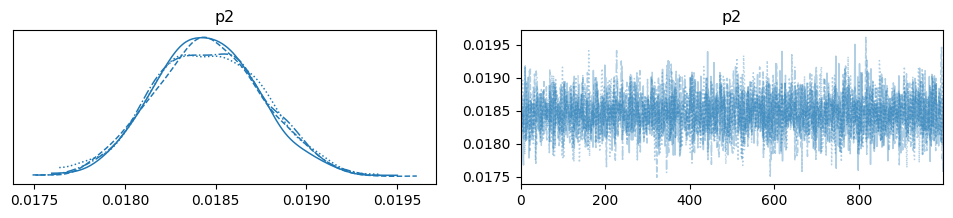

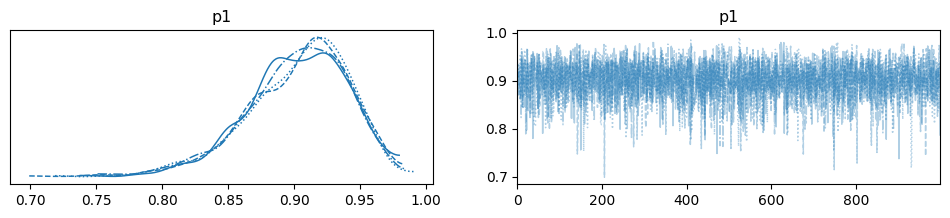

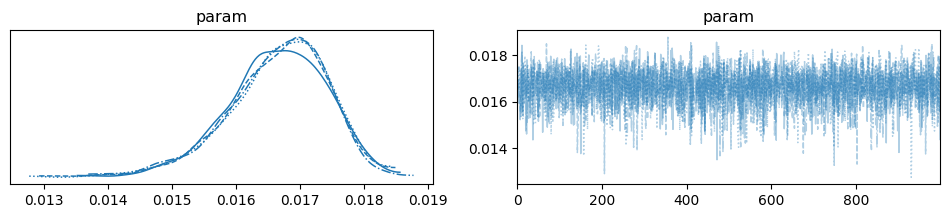

In [122]:
plot_posterior_estimates(trace_poor)

In [135]:

for name in table1:

    # poor
    n2 = len(df_topic.loc[(df_topic.loc[:, 'index'].isin(poor_indices_pure)), :])
    x2 = len(df_topic.loc[(df_topic.loc[:, 'index'].isin(poor_indices_pure)) & (df_topic.loc[:, name]==True), :])
    model_poor, trace_poor = estimator(x2, n2, table1[name][0], table1[name][1]);
    p_given_poor = trace_poor.posterior[f'param'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws
    p2_given_poor = trace_poor.posterior[f'p2'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws

    # rich
    n2 = len(df_topic.loc[(df_topic.loc[:, 'index'].isin(rich_indices_pure)), :])
    x2 = len(df_topic.loc[(df_topic.loc[:, 'index'].isin(rich_indices_pure)) & (df_topic.loc[:, name]==True), :])
    model_rich, trace_rich = estimator(x2, n2, table1[name][0], table1[name][1]);
    p_given_rich = trace_rich.posterior[f'param'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws
    p2_given_rich = trace_rich.posterior[f'p2'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws

    
    ## posterior contrasts

    # RR wrt., param
    RR_pc_poor_rich = p_given_poor / p_given_rich
    print(name, 'RR: poor/rich', np.percentile(RR_pc_poor_rich, 0.05), np.percentile(RR_pc_poor_rich,99.5))

    OR_pc_poor_rich = (p_given_poor / (1-p_given_poor)) / (p_given_rich / (1-p_given_rich))
    print(name, 'OR: poor/rich', np.percentile(OR_pc_poor_rich, 0.05), np.percentile(OR_pc_poor_rich,99.5))

    # RR wrt., p1
    RR_pc_poor_rich = p2_given_poor / p2_given_rich
    print(name, 'RR: poor/rich', np.percentile(RR_pc_poor_rich, 0.05), np.percentile(RR_pc_poor_rich,99.5))

    OR_pc_poor_rich = (p2_given_poor / (1-p2_given_poor)) / (p2_given_rich / (1-p2_given_rich))
    print(name, 'OR: poor/rich', np.percentile(OR_pc_poor_rich, 0.05), np.percentile(OR_pc_poor_rich,99.5))


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p2, p1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p2, p1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


police_cops _police officer_cop  RR: poor/rich 1.2174161846033746 2.3813960848061533
police_cops _police officer_cop  OR: poor/rich 1.2220028762450534 2.4244504241503595
police_cops _police officer_cop  RR: poor/rich 1.701310442720251 1.8765469506167114
police_cops _police officer_cop  OR: poor/rich 1.7287659679442589 1.9122255148885152


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p2, p1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p2, p1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


prison_jail_prisons RR: poor/rich 1.2546300299227966 1.7267741699404018
prison_jail_prisons OR: poor/rich 1.2601323491738277 1.7456534939655637
prison_jail_prisons RR: poor/rich 1.4010682643086079 1.58457411375042
prison_jail_prisons OR: poor/rich 1.4110816727346311 1.600152509243879


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p2, p1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p2, p1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


fast food_mcdonalds_McDonalds_mcdonald's_McDonald's RR: poor/rich 1.1908407547015636 4.423653090251318
fast food_mcdonalds_McDonalds_mcdonald's_McDonald's OR: poor/rich 1.1913074521807456 4.445941570249313
fast food_mcdonalds_McDonalds_mcdonald's_McDonald's RR: poor/rich 2.15133212040436 2.6680502726264175
fast food_mcdonalds_McDonalds_mcdonald's_McDonald's OR: poor/rich 2.1626187486365365 2.6861876968929725


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p2, p1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p2, p1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


abortion_abortions_birth control RR: poor/rich 1.3406526624271369 1.8957322941688937
abortion_abortions_birth control OR: poor/rich 1.3426051157022112 1.9019178414660227
abortion_abortions_birth control RR: poor/rich 1.422719731047233 1.833538979619361
abortion_abortions_birth control OR: poor/rich 1.4254024701844483 1.839927724501148


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p2, p1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p2, p1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


drug testing_drug test RR: poor/rich 7.180513921619636 14.36329500260416
drug testing_drug test OR: poor/rich 7.19946749478153 14.412378190830395
drug testing_drug test RR: poor/rich 7.243058252946642 14.109047962987297
drug testing_drug test OR: poor/rich 7.265814802848012 14.154177934182707


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p2, p1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p2, p1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


fat people_obese_obesity_overweight_fatties RR: poor/rich 1.9540807807393012 2.714729002813803
fat people_obese_obesity_overweight_fatties OR: poor/rich 1.9605381950088814 2.7268797985339197
fat people_obese_obesity_overweight_fatties RR: poor/rich 2.0289377166745264 2.6215826970610263
fat people_obese_obesity_overweight_fatties OR: poor/rich 2.036220940925362 2.634114725111142


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p2, p1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p2, p1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


relationship_attractive_dating RR: poor/rich 0.5310426320194852 0.9614298428642655
relationship_attractive_dating OR: poor/rich 0.5253805351402927 0.9608257935122092
relationship_attractive_dating RR: poor/rich 0.6955698521086096 0.7837415163934278
relationship_attractive_dating OR: poor/rich 0.6901098242963533 0.7795691450303109


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p2, p1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p2, p1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


marijuana_cannabis RR: poor/rich 0.911487479876022 1.3602637482669677
marijuana_cannabis OR: poor/rich 0.9112958992660852 1.3613222625335046
marijuana_cannabis RR: poor/rich 0.9376973179903727 1.3349346752356284
marijuana_cannabis OR: poor/rich 0.9375426947421825 1.3359120885205138


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p2, p1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p2, p1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


mental illness_mentally ill RR: poor/rich 8.918328170241214 13.284344990635207
mental illness_mentally ill OR: poor/rich 9.031931637944924 13.490235829801746
mental illness_mentally ill RR: poor/rich 9.353685088182297 12.916864235853911
mental illness_mentally ill OR: poor/rich 9.493041209403408 13.123823155412413


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p2, p1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p2, p1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


heroin RR: poor/rich 2.9255944919628436 4.458527013885604
heroin OR: poor/rich 2.9336316296220346 4.4753849650537045
heroin RR: poor/rich 3.081106422920374 4.404558966728367
heroin OR: poor/rich 3.0909996663832677 4.421797681750821


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p2, p1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p2, p1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


addiction_addict _addicts RR: poor/rich 5.5261605353125365 8.689828305818503
addiction_addict _addicts OR: poor/rich 5.5892841517374965 8.827821911817663
addiction_addict _addicts RR: poor/rich 6.270875051357218 8.01018533935479
addiction_addict _addicts OR: poor/rich 6.369875908826305 8.144647009059293


# Random sample of topics (irrespective of wealth context)

In [148]:
import random
random.seed(85)
for words in RQ1_selected:
    name = "_".join(words)
    comments = list(df_topic.loc[df_topic.loc[:, name]==True, 'Document'].values)
    sample = random.sample(comments, k=50)

    with open(f'samples/{name}.txt', 'w') as f:
        f.write("\n------\n".join(sample))
        

# Random sample of comments containing topical n--grams + low wealth instances

In [76]:
import random
random.seed(85)
for words in RQ1_selected:
    name = "_".join(words)
    comments = list(df_topic.loc[(df_topic.loc[:, 'index'].isin(poor_indices_pure)) & (df_topic.loc[:, name]==True), 'Document'].values)
    avail_ = len(comments)
    print(name, avail_)
    # sample = random.sample(comments, k=min(100, avail_))
    # with open(f'samples/{name}.txt', 'w') as f:
    #     f.write("\n------\n".join(sample))
        

police_cops _police officer_cop  7737
prison_jail_prisons 5082
fast food_mcdonalds_McDonalds_mcdonald's_McDonald's 2067
abortion_abortions_birth control 1379
drug testing_drug test 694
fat people_obese_obesity_overweight_fatties 1450
relationship_attractive_dating 3685
marijuana_cannabis 536
automation_AI 1205
mental illness_mentally ill 3331
heroin 979
addiction_addict _addicts 3708


# Random sample of comments containing topical n--grams + high wealth instances

In [80]:
import random
random.seed(85)
for words in RQ1_selected:
    name = "_".join(words)
    comments = list(df_topic.loc[(df_topic.loc[:, 'index'].isin(rich_indices_pure)) & (df_topic.loc[:, name]==True), 'Document'].values)
    avail_ = len(comments)
    # print(name, avail_)
    sample = random.sample(comments, k=min(100, avail_))
    with open(f'samples/{name}.txt', 'w') as f:
        f.write("\n------\n".join(sample))

FileNotFoundError: [Errno 2] No such file or directory: 'samples/police_cops _police officer_cop .txt'

### Estimator (RR in section 5)

In [148]:
def estimator(x2, n2, x1, n1, x4, n4):
    """ 
        Where x2/n2 is a point est of P(ngrams | wealth cont)
        Where x1/n1 is a point est of P(stig. | ngrams, wealth cont.)
        where x4/n4 is a point est of P(dir. | stig., ngrams, wealth cont.)
        Where param, is the estimate of P(dir, stig, ngrams | wealth context)
    
        Args:
            x4: table 4 count
            n4: table 4 total
            x2: table 2 count
            n2: table 2 total
            x1: table 1 count
            n1: table 1 total
            
    """
    
    with pm.Model() as model:
                    
        p2 = pm.LogitNormal(f'p2', 0, 1.5)  # P(contains 'police, cops' | poor comment)
        pm.Binomial(f"S2", n = n2 , p=p2, observed=x2)
            
        p1 = pm.LogitNormal(f'p1', 0, 1.5)  # P('police interaction comment' | contains 'police, cops')
        pm.Binomial(f"S1", n = n1 , p=p1, observed=x1)

        p4 = pm.LogitNormal(f'p4', 0, 1.5)  # P(contains 'police, cops' | poor comment)
        pm.Binomial(f"S4", n = n4 , p=p4, observed=x4)

        # posterior estimate of P(police interaction comment | poor comment)
        pm.Deterministic('param_new', p2*p1*p4)
        pm.Deterministic('param_old', p2*p1)
        
        trace=pm.sample()
        
    return model, trace

In [149]:
table4_poor ={
     'drug testing_drug test': (48,50),
     'mental illness_mentally ill': (39,50),
     'heroin': (43,47),
     'addiction_addict _addicts': (43, 50)
}

In [150]:
table4_rich ={
     'drug testing_drug test': (16,50),
     'mental illness_mentally ill': (16,50),
     'heroin': (20,45),
     'addiction_addict _addicts': (23, 50)
}

In [139]:
# Test
name  = 'addiction_addict _addicts'
n2 = len(df_topic.loc[(df_topic.loc[:, 'index'].isin(poor_indices_pure)), :])
x2 = len(df_topic.loc[(df_topic.loc[:, 'index'].isin(poor_indices_pure)) & (df_topic.loc[:, name]==True), :])
x1, n1 = table1[name]

x4,n4 = table4_poor[name]
model_poor, trace_poor = estimator(x2, n2, x1, n1,x4,n4);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p2, p1, p4]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


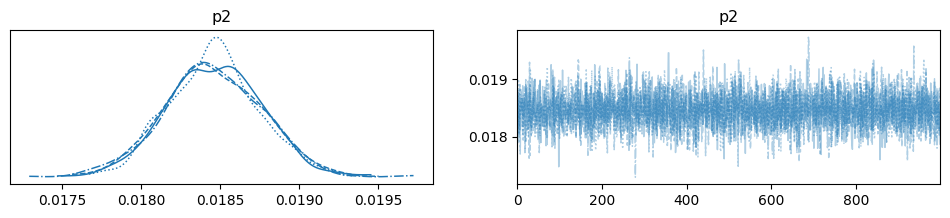

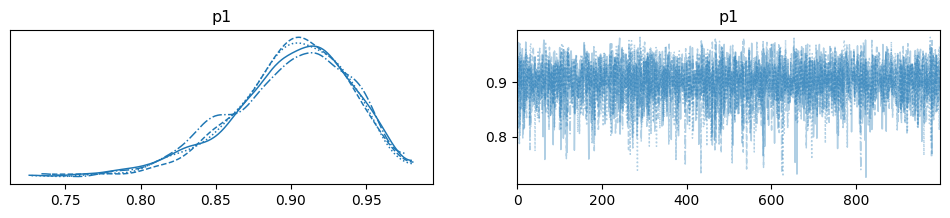

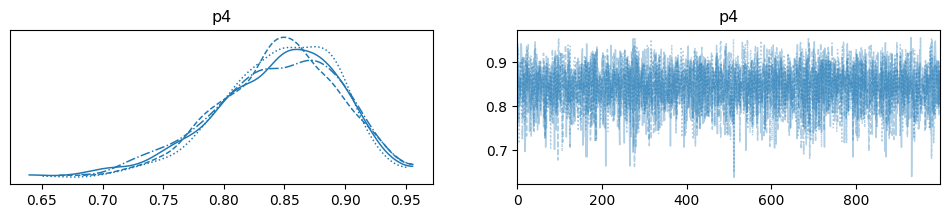

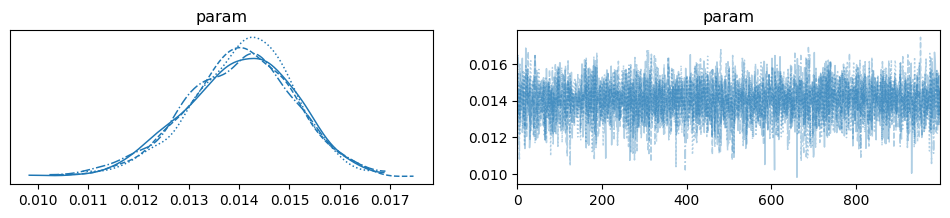

In [140]:
plot_posterior_estimates(trace_poor)

In [151]:
# Run on All ...

for name in table4_poor.keys() :

    # poor
    n2 = len(df_topic.loc[(df_topic.loc[:, 'index'].isin(poor_indices_pure)), :])
    x2 = len(df_topic.loc[(df_topic.loc[:, 'index'].isin(poor_indices_pure)) & (df_topic.loc[:, name]==True), :])
    model_poor, trace_poor = estimator(x2, n2, table1[name][0], table1[name][1], table4_poor[name][0], table4_poor[name][1]);
    p_given_poor = trace_poor.posterior[f'param_new'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws
    p_old_given_poor = trace_poor.posterior[f'param_old'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws


    # rich
    n2 = len(df_topic.loc[(df_topic.loc[:, 'index'].isin(rich_indices_pure)), :])
    x2 = len(df_topic.loc[(df_topic.loc[:, 'index'].isin(rich_indices_pure)) & (df_topic.loc[:, name]==True), :])
    model_rich, trace_rich = estimator(x2, n2, table1[name][0], table1[name][1], table4_rich[name][0], table4_rich[name][1]);
    p_given_rich = trace_rich.posterior[f'param_new'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws
    p_old_given_rich = trace_rich.posterior[f'param_old'].stack(sample=('chain', 'draw')).to_numpy()  # 1D array, dim=chains * draws

    
    ## posterior contrasts

    # RR wrt., param_new
    RR_pc_poor_rich = p_given_poor / p_given_rich
    print(name, 'RR: poor/rich', np.percentile(RR_pc_poor_rich, 0.05), np.percentile(RR_pc_poor_rich,99.5))

    OR_pc_poor_rich = (p_given_poor / (1-p_given_poor)) / (p_given_rich / (1-p_given_rich))
    print(name, 'OR: poor/rich', np.percentile(OR_pc_poor_rich, 0.05), np.percentile(OR_pc_poor_rich,99.5))

    # RR wrt., param_old
    RR_pc_poor_rich = p_old_given_poor / p_old_given_rich
    print(name, 'RR: poor/rich', np.percentile(RR_pc_poor_rich, 0.05), np.percentile(RR_pc_poor_rich,99.5))

    OR_pc_poor_rich = (p_old_given_poor / (1-p_old_given_poor)) / (p_old_given_rich / (1-p_old_given_rich))
    print(name, 'OR: poor/rich', np.percentile(OR_pc_poor_rich, 0.05), np.percentile(OR_pc_poor_rich,99.5))



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p2, p1, p4]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p2, p1, p4]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


drug testing_drug test RR: poor/rich 14.863961399386302 58.18929546942633
drug testing_drug test OR: poor/rich 14.90475960657156 58.37195850150462
drug testing_drug test RR: poor/rich 7.216786531889105 14.413895974743252
drug testing_drug test OR: poor/rich 7.237197313394914 14.456422275183062


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p2, p1, p4]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p2, p1, p4]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


mental illness_mentally ill RR: poor/rich 14.251917392284646 50.93719578156868
mental illness_mentally ill OR: poor/rich 14.40093808711591 51.52042288901123
mental illness_mentally ill RR: poor/rich 8.963707167294125 13.338347243678077
mental illness_mentally ill OR: poor/rich 9.087110872780856 13.548188310193767


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p2, p1, p4]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p2, p1, p4]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


heroin RR: poor/rich 4.524192811440146 12.394508766825663
heroin OR: poor/rich 4.5367530073523765 12.4477293663944
heroin RR: poor/rich 2.964853578203068 4.478393397398664
heroin OR: poor/rich 2.972838925168941 4.496176175399233


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p2, p1, p4]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p2, p1, p4]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


addiction_addict _addicts RR: poor/rich 7.874375001107939 22.532439535776433
addiction_addict _addicts OR: poor/rich 7.946753120022979 22.861397449501478
addiction_addict _addicts RR: poor/rich 5.3674025639695575 8.872895712632287
addiction_addict _addicts OR: poor/rich 5.42802784327573 9.001117115381671


## Poor + black + topic samples for RQ2 analysis

In [79]:
# police
import random
random.seed(85)
pool = list(df_topic.loc[
    df_topic.loc[:, 'index'].isin(poor_indices_pure) & 
    df_topic.loc[:, 'index'].isin(black_indices) & 
    (df_topic.loc[:, 'police_cops _police officer_cop ']==True), 
    'Document'
].values)
print(len(pool))

sample = random.sample(pool, k=50)

# with open(f'samples/poor+topic+black/police.txt', 'w') as f:
#     f.write("\n------\n".join(sample))

629


In [81]:
len(df_topic.loc[df_topic.loc[:, 'index'].isin(poor_indices_pure)&df_topic.loc[:, 'index'].isin(black_indices),:])

3836

In [78]:
# prison
import random
random.seed(85)
pool = list(df_topic.loc[
    df_topic.loc[:, 'index'].isin(poor_indices_pure) & 
    df_topic.loc[:, 'index'].isin(black_indices) & 
    (df_topic.loc[:, 'prison_jail_prisons']==True), 
    'Document'
].values)
print(len(pool))

sample = random.sample(pool, k=50)

# with open(f'samples/poor+topic+black/prison.txt', 'w') as f:
#     f.write("\n------\n".join(sample))

348


In [86]:
len(set(n_indices))

73568